# Tracklist Generator: Data Preparation
This notebook contains the code for the data processing of the 1001Tracklists dataset. We will take tracklist data and dictionaries containing co-occurrence information for songs and artists, and produce filtered sparse matrices to be used in recommendation models. We will also use this information to generate users based on tracklist artists. 

There are three key types of entity in this notebook and going forward:
- **Songs**: Referred to as 'Artist Name - Song Title' (e.g. "FISHER - Losing It"), these represent a single song which appears in a tracklist.
- **Artists**: Referred to by the Artist name (e.g. "FISHER"), these represent the artists who have produced or remixed a song which appears in a tracklist.
- **Users**: There is no user information directly contained in the 1001Tracklists dataset. However, each tracklist has a DJ associated with it, who curated/mixed the songs the tracklist contains. We will use this information to create 'users' that will be part of the recommendation system; this will be explained in more detail below. Users will be referred to by the DJ's name (e.g. "Annie Mac"). 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.sparse import csr_matrix
import math

import random
from typing import Tuple
import pickle
import matplotlib.pyplot as plt

## Inputs
The data originally scraped from 1001Tracklists contained 83,808 tracklists. The tracklists are stored in a pickled dictionary containing the songs, the date, and the DJ for each tracklist. Metadata about each song, including the title, associated artists, and remix/mashup information, is stored in a separate pickled dictionary.

The tracklists were used to generate weighted co-occurrence matrices between songs, between artists, and between songs and artists. Once the co-occurrence matrices were generated, we filtered the data to remove songs which occur rarely, setting a threshold on the total information (i.e. the sum of the row in the co-occurrence matrix) for a song in the song-song co-occurrence matrix. This leaves us with 31,214 songs by 10,322 artists. We store the three co-occurrence matrices (song-song, song-artist, and artist-artist) as pickled dictionaries.

First we import the dictionary containing the tracklists and convert to a DataFrame:

In [2]:
with open('tls_2021_processed.pkl','rb') as f:
    tracklists_dict = pickle.load(f)

tracklists = pd.DataFrame(tracklists_dict).T
    
print(tracklists.columns)
tracklists.head()

Index(['Date', 'Tracks', 'Artists'], dtype='object')


,Date,Tracks,Artists
0,2020-02-23,[John Legend vs. David Guetta - Conversations ...,[David Guetta]
1,2018-01-24,"[ID - ID, Eelke Kleijn ft. Therese - Shed My S...",[SOURCE RECORDINGS (SPINNIN')]
2,2019-10-07,[Party Pupils & Louis Futon ft. Tobi - One Two...,[Will Sparks]
3,2020-03-20,"[J Paul Getto - Tribute To Paul Johnson, AMTRA...",[Dieselboy]
4,2017-08-06,"[Martin Garrix - Ultra Miami 2017 Intro, Marti...",[Martin Garrix]


We also import the co-occurrence dictionaries and the song metadata dictionary:

In [3]:
with open('song_song_co_2021.pkl','rb') as f:
    song_song_co_dict = pickle.load(f)
    
with open('song_artist_co_2021.pkl','rb') as f:
    song_artist_co_dict = pickle.load(f)

with open('artist_artist_co_2021.pkl','rb') as f:
    artist_artist_co_dict = pickle.load(f)
    

In [4]:
with open('tracks_dict_2021.pkl','rb') as f:
    tracks_dict = pickle.load(f)

## User Generation
In this section we use tracklist information to generate 'users' from DJs in the dataset. We will use the tracklists associated with a DJ to create a 'click matrix' indicating the taste of each DJ based on the songs they choose to play.

We first extract a sorted list containing all song titles from the song-song co-occurrence dictionary
and create a set of these song titles. We then use this set to filter each tracklist to the songs in our population.

In [5]:
song_lst = sorted(list(song_song_co_dict))
song_set = set(song_lst)

In [6]:
tracklists['Filtered'] = tracklists['Tracks'].apply(lambda x: [y for y in x if y in song_set])

We now gather the songs that each DJ has played into a dictionary.

In [7]:
tl_user_song_dict = {}
for i in range(tracklists.shape[0]):
    row = tracklists.iloc[i,:]
    for user in row[2]:
        if user in tl_user_song_dict:
            tl_user_song_dict[user]+=row['Filtered'].copy()
        else:
            tl_user_song_dict[user]=row['Filtered'].copy()

There is some noise in this dataset because two DJs can sometimes be associated with the same tracklist even though they are not collaborating on a mix. For example, some BBC radio shows have two DJs who each provide separate hour-long guest mixes on a two-hour show. The two-hour show is then uploaded to 1001Tracklists as a single tracklist with multiple associated DJs. 

To lower the risk of associating DJs with songs they possibly did not play, we will only consider songs which a DJ has been associated with more than once. We take the log of the number of times the songs appear for that DJ to act as a preference score, and store this final selection in a new dictionary.

In [8]:
def get_repeated(lst):
    cnts = pd.Series(lst,dtype = object).value_counts()
    return cnts[cnts>1].apply(np.log)

user_selection = {}
for user in tl_user_song_dict:
    user_selection[user] = get_repeated(tl_user_song_dict[user])

Below are several examples of the top 20 associated songs by preference score for a DJ.

In [9]:
user_selection['FISHER'].iloc[:20]

FISHER - Losing It                                                        3.367296
FISHER - You Little Beauty                                                3.332205
FISHER - Stop It                                                          3.044522
FISHER - Wanna Go Dancin'                                                 2.944439
FISHER - Freaks                                                           2.890372
FISHER - Ya Kidding                                                       2.833213
Martin Ikin - Hooked                                                      2.639057
Josh Wink & Lil' Louis - How's Your Evening So Far? (Chris Lake Remix)    2.564949
Volkoder & Sam Supplier - Tornado                                         2.484907
Deeper Purpose - Elevate                                                  2.397895
Little Fritter - Cha Cha                                                  2.079442
FISHER - We FKN Love It                                                   1.945910
Jame

In [10]:
user_selection['Diplo'].iloc[:20]

The White Stripes - Seven Nation Army                                                  3.688879
GTA - Saria's Turn Up                                                                  3.465736
Steve Aoki & Diplo & Deorro ft. Steve Bays - Freak                                     3.332205
Diplo & Wax Motif - Love To The World                                                  3.258097
Diplo & Sleepy Tom - Be Right There                                                    3.218876
Paul Woolford & Diplo ft. Kareen Lomax - Looking For Me                                3.218876
Major Lazer & DJ Snake ft. MØ - Lean On                                                3.178054
Calvin Harris ft. Rihanna - This Is What You Came For (Gammer Edit)                    3.135494
Major Lazer ft. Busy Signal & The Flexican & FS Green - Watch Out For This (Bumaye)    3.135494
Diplo & Sonny Fodera - Turn Back Time                                                  3.135494
TNGHT - Higher Ground                   

In [11]:
user_selection['Oliver Heldens'].iloc[:20]

HI-LO - Renegade Mastah                                               4.234107
Oliver Heldens & Lenno - This Groove                                  3.912023
Oliver Heldens & Sidney Samson - Riverside 2099                       3.806662
Oliver Heldens & Becky Hill - Gecko (Overdrive)                       3.737670
Calvin Harris & Dua Lipa - One Kiss (Oliver Heldens Remix)            3.713572
Riton & Oliver Heldens ft. Vula - Turn Me On                          3.663562
Chic - Le Freak (Oliver Heldens Remix)                                3.583519
HI-LO & Sander van Doorn - WTF                                        3.526361
HI-LO - Men On Mars                                                   3.433987
Oliver Heldens - King Kong (HI-LO Touch)                              3.332205
Oliver Heldens & Firebeatz & Schella ft. Carla Monroe - Lift Me Up    3.295837
HI-LO & ALOK - Alien Technology                                       3.295837
Oliver Heldens ft. Shungudzo - Fire In My Soul      

To get our final user population, we filter out DJs which have a small number of songs associated with them. We set this threshold so that a DJ must have over 15 associated songs, leaving us with a total population of 1,275 users. Rather than storing song titles, we save the indices of each song from the sorted list for each user, as well as the preference scores for those songs, and save to a pickled dictionary.

In [12]:
user_selection_full = {}
for user in user_selection:
    selection = user_selection[user]
    songs = list(selection.index)
    if len(songs)>15:
        user_selection_full[user] = {}
        user_selection_full[user]['Songs'] = [song_lst.index(song) for song in songs]
        user_selection_full[user]['Scores'] = selection.values.tolist()

In [13]:
len(user_selection_full)

1275

In [14]:
with open('user_song_dict_2021.pkl','wb') as f:
    pickle.dump(user_selection_full,f)

Finally, we will take a sample of 1,000 (user, song) pairs to use as a holdout set in future model evaluation. These pairs will be removed from the final population, which is then pickled again to a separate training dictionary.

In [15]:
user_selection_inds = {}
for user in user_selection_full:
    user_selection_inds[user] = user_selection_full[user]['Songs']
    
user_lst = sorted(list(user_selection_full))

In [16]:
x_inds = []
y_inds = []
for i,user in enumerate(user_lst):
    user_selection = user_selection_inds[user]
    x_inds += [i]*len(user_selection)
    y_inds += user_selection

x_inds = np.array(x_inds)
y_inds = np.array(y_inds)

We take the sample and save the results for future use, before removing the validation pairs from our dictionary and saving this new version to a dictionary that will be used in training.

In [17]:
vad_set_size = 1000
vad_inds = random.sample(range(len(x_inds)),vad_set_size)

x_inds_vad,y_inds_vad = x_inds[vad_inds],y_inds[vad_inds]

with open('user_song_vad_inds.pkl','wb') as f:
    pickle.dump((x_inds_vad,y_inds_vad),f)

In [18]:
for j in range(1000):
    vad_user = user_lst[x_inds_vad[j]]
    vad_song_ind = y_inds_vad[j]
    
    vad_song_user_ind = user_selection_full[vad_user]['Songs'].index(vad_song_ind)
    del user_selection_full[vad_user]['Songs'][vad_song_user_ind]
    del user_selection_full[vad_user]['Scores'][vad_song_user_ind]

In [19]:
with open('user_song_dict_2021_training.pkl','wb') as f:
    pickle.dump(user_selection_full,f)

## Sparse Matrix Creation

### Songs and Artists
We will now use the co-occurrence dictionaries to create sparse co-occurrence matrices that will be converted to SparseTensors for use in the recommendation models.

First we create a sorted list of artist names, and create dictionary maps of song/artist names to indices for easy use later.

In [20]:
artist_lst = sorted(list(artist_artist_co_dict))

In [21]:
song_ind_dict = {}
for i,song in enumerate(song_lst):
    song_ind_dict[song] = i
    
artist_ind_dict = {}
for i,artist in enumerate(artist_lst):
    artist_ind_dict[artist] = i

Before we move on to the co-occurrence matrices, we will use the song metadata dictionary to create a sparse map which indicates for each song the artist(s) that produced/remixed it. Some artists will have different weights associated with a song (e.g. remix artists will have a higher weight than the original artists); these weights will be scaled so that the total of each row in the map sums to 1. The map will be created as a scipy sparse matrix and saved as a .pkl file.

In [22]:
song_artist_map_dict = {}
row_sam = []
col_sam = []
data_sam = []

for track in tracks_dict:
    song_artist_map_dict[track] = {}
    artist_weights = tracks_dict[track]['Artist weights']
    total_weight = sum(artist_weights.values())
    
    song_ind = song_ind_dict[track]
    for artist in artist_weights:
        artist_ind = artist_ind_dict[artist]
        val = artist_weights[artist]/total_weight
        song_artist_map_dict[track][artist] = val
        
        row_sam.append(song_ind)
        col_sam.append(artist_ind)
        data_sam.append(val)
        
song_artist_map_sparse = csr_matrix((data_sam,(row_sam,col_sam)))

with open('Sparse Matrices v2/song_artist_map_sparse.pkl','wb') as f:
    pickle.dump(song_artist_map_sparse,f)

We also create the transpose of this map for later use and store as a dictionary.

In [23]:
artist_song_map_dict = {}
for artist in artist_lst:
    artist_song_map_dict[artist] = {}
    
for song in song_artist_map_dict:
    song_map = song_artist_map_dict[song]
    for artist in song_map:
        artist_song_map_dict[artist][song] = song_map[artist]

We now create the song-song co-occurrence matrix. The song co-occurrence scores have a long-tailed distribution, particularly on popular songs which are played often. For example, the co-occurrence scores for the most played song in the dataset, "FISHER - Losing It", are distributed as follows:

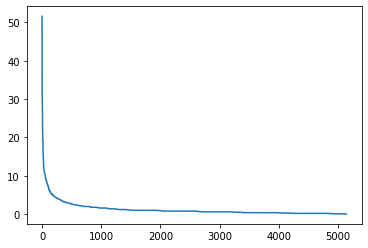

In [24]:
vals = song_song_co_dict['FISHER - Losing It'].values()
total = sum(vals)
sm = 0
sms = []
for i,val in enumerate(sorted(vals,reverse=True)):
    sm += val
    sms.append(sm)
plt.plot(range(len(vals)),sorted(vals,reverse=True))
plt.show()

The scores for "Noizu - Dance", a moderately played song, are distributed as follows:

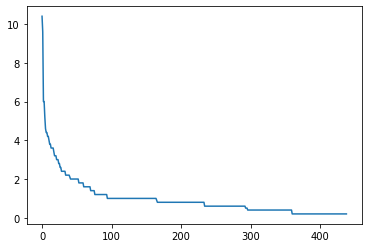

In [25]:
vals = song_song_co_dict['Noizu - Dance'].values()
total = sum(vals)
sm = 0
sms = []
for i,val in enumerate(sorted(vals,reverse=True)):
    sm += val
    sms.append(sm)
plt.plot(range(len(vals)),sorted(vals,reverse=True))
plt.show()

This noise means that the sparse matrix storing the co-occurrence matrix has a much larger memory footprint, as the number of non-zero elements is high. Due to Tensorflow GPU memory restrictions in sparse matrix multiplication, this will cause problems in training our models. To reduce this noise, we will set thresholds on the co-occurrence scores to be included in the final co-occurrence matrix. However, as the above distributions shows, the value of the threshold will be dependent on each song, as a high threshold might exclude too much for songs played less frequently. We will therefore set the threshold score so that at least 60% of the total co-occurrence information is retained for each song. By this method, we retain the most valuable 60% of total co-occurrence information, but reduce the number of non-zero elements in the sparse matrix from 4,544,472 to 1,739,847, a memory reduction to 38% of the original footprint. We will also log-scale the co-occurrence scores; in this case, we add 1 and take log base 2. 

The matrix will again be created as a scipy sparse matrix and saved as a .pkl file.

In [26]:
print('running')
row_ss = []
col_ss = []
data_ss = []
for song in song_song_co_dict:
    song_ind = song_ind_dict[song]
    song_dict = song_song_co_dict[song]
    
    song_dict_total = sum(song_dict.values())

    sm = 0
    for i,val in enumerate(sorted(song_dict.values(),reverse=True)):
        sm += val
        if sm > 0.6*song_dict_total:
            thresh_val = val
            break
            
    for song_2 in song_dict:
        song_2_ind = song_ind_dict[song_2]
        val = song_dict[song_2]
        if val >= thresh_val:
            row_ss.append(song_ind)
            col_ss.append(song_2_ind)
            data_ss.append(np.log(1+val)/np.log(math.e/2))
            
song_song_sparse = csr_matrix((data_ss,(row_ss,col_ss)))

with open('Sparse Matrices v2/song_song_sparse.pkl','wb') as f:
    pickle.dump(song_song_sparse,f)

running


We follow a similar process for the artist-artist co-occurrence matrix. There is more low-value noise in the artist matrix, as can be seen by the distributions for FISHER and Noizu:

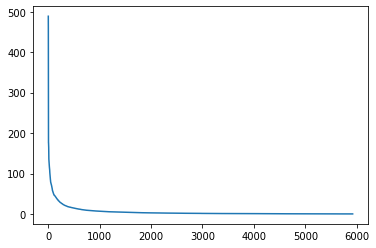

In [27]:
vals = artist_artist_co_dict['FISHER'].values()
total = sum(vals)
sm = 0
sms = []
for i,val in enumerate(sorted(vals,reverse=True)):
    sm += val
    sms.append(sm)
plt.plot(range(1,len(vals)),sorted(vals,reverse=True)[1:])
plt.show()

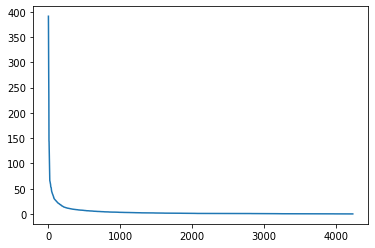

In [28]:
vals = artist_artist_co_dict['Noizu'].values()
total = sum(vals)
sm = 0
sms = []
for i,val in enumerate(sorted(vals,reverse=True)):
    sm += val
    sms.append(sm)
plt.plot(range(1,len(vals)),sorted(vals,reverse=True)[1:])
plt.show()

We can therefore set the threshold slightly higher, at 80%, and achieve a similar memory reduction, moving from 7,321,799 nonzero elements to 2,645,883, 36% of the original value. Log-scaling is performed using the natural log.

In [29]:
print('running')
row_aa = []
col_aa = []
data_aa = []
for artist_1 in artist_artist_co_dict:
    artist_1_ind = artist_ind_dict[artist_1]
    artist_1_dict = artist_artist_co_dict[artist_1]
    artist_dict_total = sum(artist_1_dict.values())
    sm = 0
    for i,val in enumerate(sorted(artist_1_dict.values(),reverse=True)):
        sm += val
        if sm > 0.8*artist_dict_total:
            thresh_val = val
            break    
    for artist_2 in artist_1_dict:
        artist_2_ind = artist_ind_dict[artist_2]
        score = artist_1_dict[artist_2]
        if score >= thresh_val:
            row_aa.append(artist_1_ind)
            col_aa.append(artist_2_ind)
            data_aa.append(np.log(1+score))
            
artist_artist_sparse = csr_matrix((data_aa,(row_aa,col_aa)))

with open('Sparse Matrices v2/artist_artist_sparse.pkl','wb') as f:
    pickle.dump(artist_artist_sparse,f)

running


The song-artist matrix is slightly more complex, as both artist and song thresholds must be taken into consideration. This matrix is more dense, and the score distributions in this matrix also has a fatter tail for less popular songs:

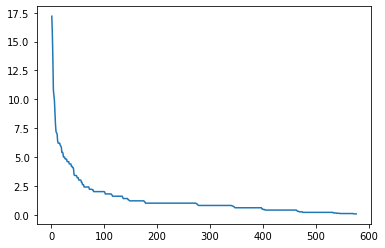

In [30]:
vals = song_artist_co_dict['Noizu - Dance'].values()
total = sum(vals)
sm = 0
sms = []
for i,val in enumerate(sorted(vals,reverse=True)):
    sm += val
    sms.append(sm)
plt.plot(range(1,len(vals)),sorted(vals,reverse=True)[1:])
plt.show()

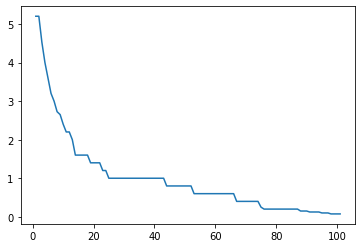

In [31]:
vals = song_artist_co_dict['MPH - Deja Vu'].values()
total = sum(vals)
sm = 0
sms = []
for i,val in enumerate(sorted(vals,reverse=True)):
    sm += val
    sms.append(sm)
plt.plot(range(1,len(vals)),sorted(vals,reverse=True)[1:])
plt.show()

The thresholds for both song and artist are set at 60%. We first create a transposed version of the song-artist co-occurrence matrix, and calculate the threshold value for each artist. 

In [32]:
print('running')
artist_song_co_dict = {}
for artist in artist_lst:
    artist_song_co_dict[artist] = {}
    
    
for song in song_lst:
    song_artist_co_single = song_artist_co_dict[song]
    for artist in song_artist_co_single:
        artist_song_co_dict[artist][song] = song_artist_co_single[artist]
        
artist_song_co_thresh = {}
for artist in artist_lst:
    artist_dict = artist_song_co_dict[artist]
    artist_song_co_total = sum(artist_dict.values())

    sm = 0
    for i,val in enumerate(sorted(artist_dict.values(),reverse=True)):
        sm += val
        if sm > 0.5*artist_song_co_total:
            thresh_val = val
            break
    artist_song_co_thresh[artist] = thresh_val

running


We then perform the same process as for the other matrices, except we set the threshold value at the minimum of the song threshold and the artist threshold. This reduces the number of nonzero elements from 6,795,862 to 2,077,447, 31% of the original memory footprint.

In [33]:
print('running')
row_sa = []
col_sa = []
data_sa = []
for song in song_artist_co_dict:
    song_ind = song_ind_dict[song]
    song_dict = song_artist_co_dict[song]
    song_dict_total = sum(song_dict.values())
    
    sm = 0
    for i,val in enumerate(sorted(song_dict.values(),reverse=True)):
        sm += val
        if sm > 0.5*song_dict_total:
            thresh_val = val
            break
    
    for artist in song_dict:
        artist_ind = artist_ind_dict[artist]
        artist_dict_thresh = artist_song_co_thresh[artist]
        
        thresh = np.min([thresh_val,artist_dict_thresh])
        val = song_dict[artist]
        if val >= thresh:
            row_sa.append(song_ind)
            col_sa.append(artist_ind)
            data_sa.append(np.log(1+val))
            
song_artist_sparse = csr_matrix((data_sa,(row_sa,col_sa)))

with open('Sparse Matrices v2/song_artist_sparse.pkl','wb') as f:
    pickle.dump(song_artist_sparse,f)

running


### Users
We will now create a sparse matrix containing the 'click matrix' for the user-song selections created above, using the log of the count as a score. We first create a user-index map and a dictionary of associated users for each song.

In [34]:
user_ind_dict = {}
for i,user in enumerate(user_lst):
    user_ind_dict[user] = i
    
song_user_dict = {}
for song in song_lst:
    song_user_dict[song] = {}
    
for user in user_lst:
    user_dict = user_selection_full[user]
    for i,song_ind in enumerate(user_dict['Songs']):
        song_user_dict[song_lst[song_ind]][user] = user_dict['Scores'][i]

We now create the sparse click matrix. It will be useful down the line to have versions of this matrix scaled by user and scaled by song, so we create both now.

In [35]:
row_us = []
col_us = []
data_us = []
for user in user_selection_full:
    user_ind = user_ind_dict[user]
    user_dict = user_selection_full[user]
    user_scores = user_dict['Scores']
    user_total = np.sum(user_scores)
    for i,song_ind in enumerate(user_dict['Songs']):
        row_us.append(user_ind)
        col_us.append(song_ind)
        data_us.append(user_scores[i]/user_total)
        
user_song_sparse_scaled_user = csr_matrix((data_us,(row_us,col_us)))

with open('Sparse Matrices v2/user_song_sparse_scaled_user.pkl','wb') as f:
    pickle.dump(user_song_sparse_scaled_user,f)

row_su = []
col_su = []
data_su = []
for song in song_lst:
    song_ind = song_ind_dict[song]
    song_dict = song_user_dict[song]
    song_total = sum(song_dict.values())
    for user in song_dict:
        user_ind = user_ind_dict[user]
        row_su.append(user_ind)
        col_su.append(song_ind)
        data_su.append(song_dict[user]/song_total)
        
user_song_sparse_scaled_song = csr_matrix((data_su,(row_su,col_su)))

with open('Sparse Matrices v2/user_song_sparse_scaled_song.pkl','wb') as f:
    pickle.dump(user_song_sparse_scaled_song,f)

We also want to create similar click matrices for users and artists. The user-scaled matrix can be created by a simple matrix multiplication with the song-artist map:

In [36]:
user_artist_sparse_scaled_user = user_song_sparse_scaled_user @ song_artist_map_sparse

with open('Sparse Matrices v2/user_artist_sparse_scaled_user.pkl','wb') as f:
    pickle.dump(user_artist_sparse_scaled_user,f)


While the artist-scaled matrix is created with the transposed version of the song-artist map created above:

In [37]:
row_au = []
col_au = []
data_au = []
for artist in artist_lst:
    artist_song_map = {}
    artist_song_map_full = artist_song_map_dict[artist]
    for song in artist_song_map_full:
        if song_user_dict[song]!={}:
            artist_song_map[song] = artist_song_map_full[song]
    artist_map_total = sum(artist_song_map.values())
    artist_ind = artist_ind_dict[artist]
    for song in artist_song_map:
        song_dict = song_user_dict[song]
        song_total = sum(song_dict.values())
        for user in song_dict:
            user_ind = user_ind_dict[user]
            row_au.append(user_ind)
            col_au.append(artist_ind)
            data_au.append(artist_song_map[song]/(artist_map_total*song_total))
            
user_artist_sparse_scaled_artist = csr_matrix((data_au,(row_au,col_au)))

with open('Sparse Matrices v2/user_artist_sparse_scaled_artist.pkl','wb') as f:
    pickle.dump(user_artist_sparse_scaled_artist,f)

For the graph algorithms used to generate our embeddings, we will need an adjacency matrix for the users. Following the suggestion in Sun et al.'s [Multi-Graph Convolution Collaborative Filtering (2020)](https://arxiv.org/abs/2001.00267), we create this by taking the cosine similarity of the user-song click matrix. To do this, we first create a dense version of the click matrix, then use sklearn's cosine similarity function. We save the result as a pickled numpy array.

In [38]:
id_mat = np.identity(31214)
user_selection_vecs = [np.sum(
    id_mat[user_selection_full[user]['Songs']],axis=0) for user in user_lst]

In [39]:
user_selection_mat = np.stack(user_selection_vecs).astype(np.float32)+1e-20

from sklearn.metrics.pairwise import cosine_similarity
user_adj = cosine_similarity(user_selection_mat)

In [40]:
with open('Sparse Matrices v2/user_adj.pkl','wb') as f:
    pickle.dump(user_adj,f)
    
with open('Sparse Matrices v2/user_selection_mat_sparse.pkl','wb') as f:
    pickle.dump(csr_matrix(user_selection_mat),f)

Finally, we save the song, artist, and user lists for future reference.

In [41]:
with open('Sparse Matrices v2/song_lst.pkl','wb') as f:
    pickle.dump(song_lst,f)
    
with open('Sparse Matrices v2/artist_lst.pkl','wb') as f:
    pickle.dump(artist_lst,f)
    
with open('Sparse Matrices v2/user_lst.pkl','wb') as f:
    pickle.dump(user_lst,f)